This notebook demonstrates how to perform standard (Kronecker) multitask regression with kernels.IndexKernel.

This differs from the [hadamard_multitask_gp_regression example notebook](https://github.com/cornellius-gp/gpytorch/blob/master/examples/hadamard_multitask_gp_regression.ipynb) in one key way:
- Here, we assume that we want to learn **all tasks per input**. (The kernel that we learn is expressed as a Krnoecker product of an input kernel and a task kernel).
- In the other notebook, we assume that we want to learn one tasks per input.  For each input, we specify the task of the input that we care about. (The kernel in that notebook is the Hadamard product of an input kernel and a task kernel).

Multitask regression, first introduced in [this paper](https://papers.nips.cc/paper/3189-multi-task-gaussian-process-prediction.pdf) learns similarities in the outputs simultaneously. It's useful when you are performing regression on multiple functions that share the same inputs, especially if they have similarities (such as being sinusodial). 

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Training points are every 0.1 in [0,1] (note that they're the same for both tasks)
train_x = torch.linspace(0, 1, 100)

# y1 function is sin(2*pi*x) with noise N(0, 0.04)
train_y1 = torch.sin(train_x.data * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2
# y2 function is cos(2*pi*x) with noise N(0, 0.04)
train_y2 = torch.cos(train_x.data * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2

# Create a train_y which interleaves the two
train_y = torch.stack([train_y1, train_y2], -1).view(-1)

In [3]:
from torch import optim
from gpytorch.kernels import RBFKernel, IndexKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

In [4]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        # Default bounds on mean are (-1e10, 1e10)
        self.mean_module = ConstantMean()
        # We use the very common RBF kernel
        self.covar_module = RBFKernel()
        # We learn an IndexKernel for 2 tasks
        # (so we'll actually learn 2x2=4 tasks with correlations)
        self.task_covar_module = IndexKernel(n_tasks=2, rank=1)
        # We want to learn two tasks, which we will assign indices 0 and 1
        self.register_buffer('task_indices', torch.LongTensor([0, 1]))

    def forward(self, x):
        # Get predictive mean
        mean_x = self.mean_module(x)
        # Since we may have 2 tasks, we'll have to repeat the mean
        # for as many tasks as we have
        mean_x = mean_x.repeat(2)
        
        # Get the input-specific covariance
        covar_x = self.covar_module(x)
        # # Get the task-specific covariance
        covar_i = self.task_covar_module(self.task_indices)
        # The covariance matrix that we use is the kronecker product between the input and task covar matrices
        # Here we use a "KroneckerProductLazyVariable" to do the kronecker product
        # This prevents us from actually computing the complete matrix, and we instead get major computation savings
        covar_xi = gpytorch.lazy.KroneckerProductLazyVariable(covar_i, covar_x)
        
        return GaussianRandomVariable(mean_x, covar_xi)

# Gaussian likelihood is used for regression to give predictive mean+variance
# and learn noise
likelihood = GaussianLikelihood()
model = MultitaskGPModel(train_x, train_y, likelihood)

In [5]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

n_iter = 50
for i in range(n_iter):
    # Zero prev backpropped gradients
    optimizer.zero_grad()
    # Make predictions from training data
    # Again, note feeding duplicated x_data and indices indicating which task
    output = model(train_x)
    # Calc the loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, n_iter, loss.item()))
    optimizer.step()

Iter 1/50 - Loss: 1.077
Iter 2/50 - Loss: 1.026
Iter 3/50 - Loss: 0.977
Iter 4/50 - Loss: 0.930
Iter 5/50 - Loss: 0.886
Iter 6/50 - Loss: 0.834
Iter 7/50 - Loss: 0.785
Iter 8/50 - Loss: 0.741
Iter 9/50 - Loss: 0.685
Iter 10/50 - Loss: 0.652
Iter 11/50 - Loss: 0.590
Iter 12/50 - Loss: 0.562
Iter 13/50 - Loss: 0.511
Iter 14/50 - Loss: 0.476
Iter 15/50 - Loss: 0.446
Iter 16/50 - Loss: 0.409
Iter 17/50 - Loss: 0.362
Iter 18/50 - Loss: 0.325
Iter 19/50 - Loss: 0.261
Iter 20/50 - Loss: 0.250
Iter 21/50 - Loss: 0.199
Iter 22/50 - Loss: 0.181
Iter 23/50 - Loss: 0.144
Iter 24/50 - Loss: 0.133
Iter 25/50 - Loss: 0.092
Iter 26/50 - Loss: 0.077
Iter 27/50 - Loss: 0.061
Iter 28/50 - Loss: 0.019
Iter 29/50 - Loss: 0.016
Iter 30/50 - Loss: -0.017
Iter 31/50 - Loss: -0.016
Iter 32/50 - Loss: -0.021
Iter 33/50 - Loss: -0.056
Iter 34/50 - Loss: -0.046
Iter 35/50 - Loss: -0.039
Iter 36/50 - Loss: -0.051
Iter 37/50 - Loss: -0.046
Iter 38/50 - Loss: -0.045
Iter 39/50 - Loss: -0.040
Iter 40/50 - Loss: -0.02

/home/gpleiss/anaconda3/envs/gpytorch/lib/python3.6/site-packages/matplotlib/font_manager.py:1339: UserWarning: findfont: Font family ['Times'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/gpleiss/anaconda3/envs/gpytorch/lib/python3.6/site-packages/matplotlib/font_manager.py:1339: UserWarning: findfont: Font family ['Times'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


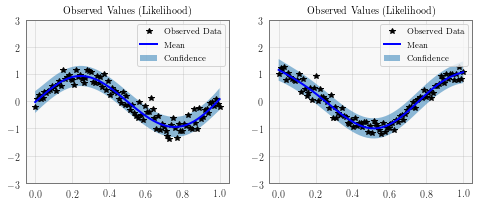

In [6]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))
# Test points every 0.02 in [0,1]

# Make predictions
with torch.no_grad():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))
    # Get mean
    mean = observed_pred.mean()
    mean = mean.view(51, 2)
    # Get lower and upper confidence bounds
    lower, upper = observed_pred.confidence_region()
    lower = lower.view(51, 2)
    upper = upper.view(51, 2)
# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task

# Define plotting function
def ax_plot():

    # Plot training data as black stars
    y1_ax.plot(train_x.detach().numpy(), train_y1.detach().numpy(), 'k*')
    # Predictive mean as blue line
    y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
    # Shade in confidence 
    y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
    y1_ax.set_ylim([-3, 3])
    y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
    y1_ax.set_title('Observed Values (Likelihood)')
    
    # Plot training data as black stars
    y2_ax.plot(train_x.detach().numpy(), train_y2.detach().numpy(), 'k*')
    # Predictive mean as blue line
    y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
    # Shade in confidence 
    y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
    y2_ax.set_ylim([-3, 3])
    y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
    y2_ax.set_title('Observed Values (Likelihood)')

# Plot both tasks
ax_plot()